# Case Study 3

Build a spam classifier using naive Bayes and clustering. You will have to create your own dataset from the input messages. Be sure to document how you created your dataset.

## Import Libraries

In [1]:
import email
import os
import re
import string
import warnings
from collections import Counter
from html.parser import HTMLParser
from os import chdir, getcwd, listdir
from os.path import dirname, isfile, join, realpath

import little_mallet_wrapper as lmw
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn.cluster as cluster
from bs4 import BeautifulSoup
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from scipy.sparse import csr_matrix

# Import sklearn libraries
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    silhouette_samples,
    silhouette_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
%matplotlib inline

## Examine the Data

In [2]:
# Look at the contents of the current directory
os.listdir('.')

['categories_by_topics.pdf',
 'Farrow_Matt_case_study_3.docx',
 '.DS_Store',
 '~$rrow_Matt_case_study_3.docx',
 'mallet.topic_keys.15',
 'mallet.topic_distributions.15',
 'CleanShot 2022-05-22 at 12.45.01@2x.png',
 'training.txt',
 'Farrow_Matt_case_study_3.py',
 'mallet.word_weights.15',
 'mallet.training',
 'mallet.diagnostics.15.xml',
 'mallet.model.15',
 'SpamAssassinMessages',
 '.ipynb_checkpoints',
 'Farrow_Matt_case_study_3.ipynb',
 'data']

In [3]:
# Look at the contents of the `SpamAssassinMessages` folder
os.listdir('./SpamAssassinMessages')

['spam', 'hard_ham', 'spam_2', '.DS_Store', 'easy_ham', 'easy_ham_2']

In [4]:
# Glance at one of the emails to understand the raw data
os.system('cat ./SpamAssassinMessages/easy_ham/2551.3b1f94418de5bd544c977b44bcc7e740')

From rssfeeds@jmason.org  Thu Oct 10 12:32:34 2002
Return-Path: <rssfeeds@example.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id 89EE616F03
	for <jm@localhost>; Thu, 10 Oct 2002 12:32:33 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Thu, 10 Oct 2002 12:32:33 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g9A84QK14194 for
    <jm@jmason.org>; Thu, 10 Oct 2002 09:04:26 +0100
Message-Id: <200210100804.g9A84QK14194@dogma.slashnull.org>
To: yyyy@example.com
From: newscientist <rssfeeds@example.com>
Subject: Critical US satellites could be hacked
Date: Thu, 10 Oct 2002 08:04:26 -0000
Content-Type: text/plain; encoding=utf-8
X-Spam-Status: No, hits=-959.4 required=5.0
	tests=AWL,DATE_IN_PAST_03_06,T_NONSENSE_FROM_00_10,
	      T_NONSENSE_FROM_10_20,T_NO

0

NSENSE_FROM_20_30,
	      T_NONSENSE_FROM_30_40,T_NONSENSE_FROM_40_50,
	      T_NONSENSE_FROM_50_60,T_NONSENSE_FROM_60_70,
	      T_NONSENSE_FROM_70_80,T_NONSENSE_FROM_80_90,
	      T_NONSENSE_FROM_90_91,T_NONSENSE_FROM_91_92,
	      T_NONSENSE_FROM_92_93,T_NONSENSE_FROM_93_94,
	      T_NONSENSE_FROM_94_95,T_NONSENSE_FROM_95_96,
	      T_NONSENSE_FROM_96_97,T_NONSENSE_FROM_97_98,
	      T_NONSENSE_FROM_98_99,T_NONSENSE_FROM_99_100
	version=2.50-cvs
X-Spam-Level: 

URL: http://www.newsisfree.com/click/-3,8708820,1440/
Date: Not supplied

Military communications could be jammed or intercepted and satellites thrown 
off course or destroyed, a new US study warns




## Read in Email Messages

In [5]:
def get_cwd():
    active_dir = getcwd()
    return active_dir

def main():
    
    get_cwd()
    
    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'
            ] 
    
    res_frame = pd.DataFrame()
    
    emails = []

    bodies = []
        
    for d in directories:
        mypath = getcwd() + '/data/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.close()
            
            with open(mypath + file, encoding='latin1') as f:
                body = f.read()
                f.close()
                
            msg = email.message_from_string(str(body))
            tmpStr = ''
            
            if msg.is_multipart():
                for payload in msg.get_payload():
                    tmpStr = ' '.join(str(payload.get_payload()))
                bodies.append(tmpStr)
            else:
                bodies.append(str(msg.get_payload()))
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            for line in lines:

                n_lines += 1
                if "Subject: Re: " in line:
                   in_reply_count += 1
                if "Subject: " in line:
                   s_line = line.strip().replace('Subject: ','')
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line)
                if "content-type: multipart" in line.lower():
                   attachments += 1
                if line == "\n":
                   blank_lines.append(n_lines)
        
            temp_frame = pd.DataFrame({
                        'directory':d,    
                        'filename':file,
                        'is_spam':['Y' if 'spam' in d else 'N'],
                        'in_reply': ['Y' if in_reply_count > 0 else 'N'], 
                        'subj_caps': ['Y' if sub_line_all_caps > 0 else 'N'], 
                        'attachments': ['Y' if attachments > 0 else 'N'],
                        'body_lines': [0 if len(blank_lines) == 0 else min(blank_lines)]
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)

            # Append body of email to collection
            text = ' '.join(lines)
            emails.append(text)
    
    # Add emails
    return res_frame, emails, bodies

df, emails, bodies = main()

### Look at the Results

In [6]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   directory    9353 non-null   object
 1   filename     9353 non-null   object
 2   is_spam      9353 non-null   object
 3   in_reply     9353 non-null   object
 4   subj_caps    9353 non-null   object
 5   attachments  9353 non-null   object
 6   body_lines   9353 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 511.6+ KB


,directory,filename,is_spam,in_reply,subj_caps,attachments,body_lines
9258,spam_2,01226.4aaf4e328bd55191a1c46bc374069048,Y,N,N,N,29
7542,spam,00103.2eef38789b4ecce796e7e8dbe718e3d2,Y,N,N,N,19
816,easy_ham,02329.26c7e9813ea8b29dce213bc8275e2904,N,N,N,N,19
8707,spam_2,00260.49cb520f5d726da6f1ec32d0e4d2e38f,Y,N,N,N,22
4211,easy_ham,01751.bff303bb4466a91b0f88491b207e8ed8,N,N,N,Y,7


In [7]:
df = df.replace(['Y','N'],[1,0])
df.sample(5)

,directory,filename,is_spam,in_reply,subj_caps,attachments,body_lines
8662,spam_2,00485.94b2cb3aa454e6f6701c42cb1fd35ffe,1,0,0,0,24
498,easy_ham,01290.41e79a15cd074594f220dfaed53d51aa,0,1,0,0,51
8535,spam_2,00336.b937e6ad1deae309e248580a6fec85d8,1,0,0,0,27
2518,easy_ham,00687.a044e978152b1411bd3ea6ddc0f537b2,0,1,0,0,51
9140,spam_2,00410.fb7b31cdd9d053f8b446da7ce89383fa,1,0,0,1,413


## Clean up Text

### Perform Cleanup Using `nltk`

In [8]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lowercase and remove special characters to form a normalized document
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = nltk.word_tokenize(doc)
    
    # filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove numbers
    filtered_tokens = [token for token in filtered_tokens if not token.isdigit()]

    # Remove short tokens
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2]

    # re-create a normalized document
    doc = ' '.join(filtered_tokens)
    return doc

normalize_text = np.vectorize(normalize_document)
norm_text = normalize_text(emails)

print(type(norm_text),len(norm_text))

<class 'numpy.ndarray'> 9353


### Put the Cleaned Text into a Dataframe

In [9]:
norm_text_2 = pd.DataFrame(norm_text)
directory = pd.DataFrame(df['directory'])
combined_df = pd.concat([norm_text_2,directory],axis=1)
combined_df.columns = ['text','directory']
combined_df['text'] = combined_df['text'].apply(lambda x: x.split())
combined_df

,text,directory
0,"[rssfeeds, jmason, org, mon, sep, return, path...",easy_ham
1,"[fork, admin, xent, com, tue, sep, return, pat...",easy_ham
2,"[fork, admin, xent, com, tue, sep, return, pat...",easy_ham
3,"[rpm, list, admin, freshrpms, net, mon, sep, r...",easy_ham
4,"[secprog, return, jmason, org, securityfocus, ...",easy_ham
...,...,...
9348,"[687ifsuy, bol, com, tue, aug, return, path, 6...",spam_2
9349,"[mraimecoilcipc, msn, com, mon, jul, return, p...",spam_2
9350,"[fork, admin, xent, com, thu, aug, return, pat...",spam_2
9351,"[niddeel, hotmail, com, tue, aug, return, path...",spam_2


### Create a Tf-IDF Matrix

In [10]:
tf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=.8, stop_words=stop_words, norm='l2')
tf_matrix = tf.fit_transform(norm_text)

print(tf_matrix.shape)

(9353, 166742)


## Perform Topic Modeling

In [11]:
os.environ['MALLET_HOME'] = '/Users/matt/mallet-2.0.8'
path_to_mallet = '/Users/matt/mallet-2.0.8/bin/mallet'

# Define training data
combined_df['text_2'] = combined_df['text'].apply(lambda x: ' '.join(x))
training_data = [lmw.process_string(t) for t in combined_df['text_2']]
training_data = [d for d in training_data if d.strip()]

# Number of topics that user specifies
num_topics = 15

# Define output directory
output_directory_path = '/Users/matt/Documents/GitHub/7333-qtw/Case Study 3'

topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, 
                                                              output_directory_path, 
                                                              num_topics, 
                                                              training_data)

Importing data...
Complete
Training topic model...


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 19655
total tokens: 4823074
<10> LL/token: -7.65818
<20> LL/token: -7.28169
<30> LL/token: -7.18082
<40> LL/token: -7.13762

0	0.33333	com net received localhost jul netnoteinc esmtp content aug zzzz http mon smtp mail subject labs pro html version webnote 
1	0.33333	font size color face nbsp arial align verdana NUM center style width div NUMe sans span serif helvetica href table 
2	0.33333	org localhost linux received ilug com esmtp dogma slashnull sep jmason lugh aug ist oct tuatha date rssfeeds taint tue 
3	0.33333	com xent fork NUM list localhost received freshrpms net rpm org mailto admin esmtp http subject sep zzzlist request postfix 
4	0.33333	NUM width http src img height gif www font border cnet href bgcolor table com/b online clickthru com/click size alt 
5	0.33333	http www com html radio NUM net org news weblogs com/NUM php theregister normal blogspot article htm small weblog mediaunspun 
6	0.33333

<200> LL/token: -7.02983
[beta: 0.0178] 
<210> LL/token: -7.01022
[beta: 0.01839] 
<220> LL/token: -6.97834
[beta: 0.01856] 
<230> LL/token: -6.95789
[beta: 0.01871] 
<240> LL/token: -6.94395

0	0.09972	com net received localhost jul esmtp org netnoteinc content http zzzz aug mail mon sep subject smtp html message date 
1	0.03512	font NUM size face color nbsp arial align verdana style center div NUMe span width helvetica sans serif option aNUM 
2	0.11612	org localhost linux ilug received com esmtp slashnull dogma lugh jmason oct aug tuatha ist http rssfeeds date sep tue 
3	0.11493	com xent fork NUM localhost list received org sep mailto admin esmtp http subject postfix request taint spamassassin net version 
4	0.01954	NUM width http height src img gif font www border cnet href com/b bgcolor table online clickthru com/click size zdnet 
5	0.0132	http www com html NUM radio net org weblogs php news com/NUM theregister blogspot normal mediaunspun href bgcolor hover footer 
6	0.05545	NUM ne

[beta: 0.01927] 
<400> LL/token: -6.90389
[beta: 0.01928] 
<410> LL/token: -6.90261
[beta: 0.01927] 
<420> LL/token: -6.90274
[beta: 0.01928] 
<430> LL/token: -6.90177
[beta: 0.01926] 
<440> LL/token: -6.90165

0	0.04857	com net received localhost org jul esmtp netnoteinc content http zzzz aug mail mon sep subject smtp html date message 
1	0.01996	font NUM size color face nbsp arial align verdana style center div NUMe span width serif sans option helvetica aNUM 
2	0.05367	org localhost linux ilug received com esmtp NUM lugh slashnull dogma jmason oct aug tuatha http ist rssfeeds sep date 
3	0.04611	com xent fork NUM localhost list org received sep mailto admin esmtp http subject postfix request taint spamassassin net version 
4	0.01088	NUM width http height src img gif font www border cnet href com/b bgcolor table online clickthru com/click size zdnet 
5	0.00551	http www com html NUM radio net org weblogs php news theregister com/NUM blogspot normal bgcolor mediaunspun hover footer tab

[beta: 0.0193] 
<600> LL/token: -6.89822
[beta: 0.01931] 
<610> LL/token: -6.89754
[beta: 0.01928] 
<620> LL/token: -6.89779
[beta: 0.01929] 
<630> LL/token: -6.89789
[beta: 0.01929] 
<640> LL/token: -6.8976

0	0.04769	com net received localhost org jul esmtp netnoteinc content http zzzz aug mail mon sep subject smtp message date html 
1	0.01956	font NUM size color face nbsp arial align verdana style center div NUMe span width serif sans option helvetica aNUM 
2	0.05059	org localhost linux ilug received com esmtp NUM lugh slashnull dogma jmason oct aug tuatha http ist rssfeeds date sep 
3	0.04478	com xent fork NUM localhost list org received sep mailto admin esmtp http subject postfix request taint spamassassin net version 
4	0.01043	NUM width http height src img gif font www border cnet href com/b bgcolor table online clickthru com/click size zdnet 
5	0.00493	http www com html NUM radio net weblogs org php news theregister com/NUM normal blogspot bgcolor mediaunspun href table hover 


[beta: 0.01928] 
<800> LL/token: -6.89596
[beta: 0.01929] 
<810> LL/token: -6.89608
[beta: 0.01927] 
<820> LL/token: -6.89599
[beta: 0.0193] 
<830> LL/token: -6.89554
[beta: 0.01932] 
<840> LL/token: -6.89622

0	0.04815	com net received localhost org jul esmtp netnoteinc content http zzzz aug mail mon sep subject smtp message date html 
1	0.01921	font NUM size color face nbsp arial align verdana style center div NUMe span width sans serif option helvetica aNUM 
2	0.04961	org localhost linux ilug received com esmtp NUM lugh slashnull dogma jmason oct aug tuatha http ist rssfeeds date sep 
3	0.04476	com xent fork NUM localhost list org received sep mailto admin esmtp http subject postfix request taint spamassassin net version 
4	0.01066	NUM width http height src img gif font www border cnet href com/b bgcolor table online clickthru com/click size zdnet 
5	0.00486	http www com html NUM radio net org php weblogs news com/NUM theregister normal blogspot table mediaunspun bgcolor footer hove

[beta: 0.01928] 
<1000> LL/token: -6.89501

Total time: 5 minutes 57 seconds


Complete


In [12]:
# Organizing the results into a dictionary
topic_word_probability_dict = lmw.load_topic_word_distributions(output_directory_path + '/mallet.word_weights.' + str(num_topics))
len(topic_word_probability_dict)

for _topic, _word_probability_dict in topic_word_probability_dict.items():
    print('Topic', _topic)
    for _word, _probability in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)[:15]:
        print(round(_probability, 4), '\t', _word)
    print()

Topic 0
0.0607 	 com
0.0288 	 net
0.0239 	 received
0.0195 	 localhost
0.0125 	 org
0.0115 	 jul
0.0114 	 esmtp
0.0109 	 netnoteinc
0.0101 	 content
0.0101 	 http
0.0097 	 zzzz
0.009 	 aug
0.0085 	 mail
0.0076 	 mon
0.0075 	 sep

Topic 1
0.1272 	 font
0.0445 	 NUM
0.0428 	 size
0.0337 	 color
0.0329 	 face
0.0293 	 nbsp
0.0208 	 arial
0.0183 	 align
0.0148 	 verdana
0.0147 	 style
0.0134 	 center
0.0125 	 div
0.0116 	 NUMe
0.0105 	 span
0.0098 	 width

Topic 2
0.0491 	 org
0.039 	 localhost
0.0382 	 linux
0.0265 	 ilug
0.0253 	 received
0.0226 	 com
0.0168 	 esmtp
0.0164 	 NUM
0.014 	 lugh
0.0138 	 slashnull
0.0137 	 dogma
0.0127 	 jmason
0.012 	 oct
0.0118 	 aug
0.0117 	 tuatha

Topic 3
0.0687 	 com
0.0561 	 xent
0.0475 	 fork
0.0305 	 NUM
0.0233 	 localhost
0.0225 	 list
0.0213 	 org
0.0211 	 received
0.0152 	 sep
0.0148 	 mailto
0.0144 	 admin
0.0141 	 http
0.014 	 esmtp
0.0137 	 subject
0.0113 	 postfix

Topic 4
0.0854 	 NUM
0.0669 	 width
0.0579 	 http
0.0399 	 height
0.0387 	 src

### Examine Topics by Category

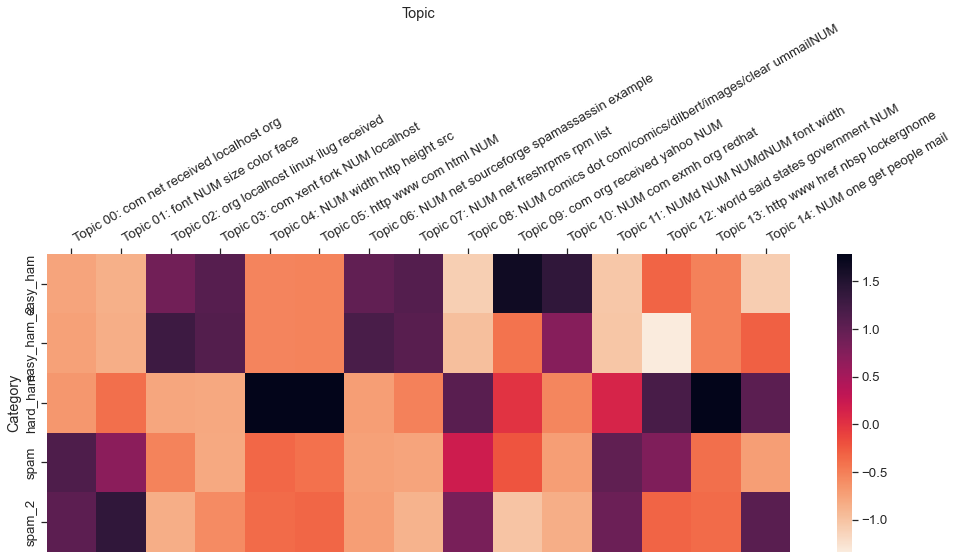

In [13]:
directory = combined_df['directory'].tolist()

target_labels = ["easy_ham", 
                 "easy_ham_2", 
                 "hard_ham", 
                 "spam", 
                 "spam_2"]

lmw.plot_categories_by_topics_heatmap(directory,
                                      topic_distributions,
                                      topic_keys, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(14,8))

In [14]:
print('Spam directory is related to the following topics : \n', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[0,0],'\t', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[3,0],'\t', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[4,0])
print('\n','Spam_2 directory is related to the following topics : \n', pd.DataFrame([','.join(i) for i in topic_keys]).iloc[0,0],'\n',pd.DataFrame([','.join(i) for i in topic_keys]).iloc[5,0])

Spam directory is related to the following topics : 
 com,net,received,localhost,org,jul,esmtp,netnoteinc,http,content,zzzz,aug,mail,mon,sep,subject,smtp,NUM,message,date 	 com,xent,fork,NUM,localhost,list,org,received,sep,mailto,admin,http,esmtp,subject,postfix,request,taint,spamassassin,net,version 	 NUM,width,http,height,src,img,gif,font,www,border,cnet,href,com/b,bgcolor,table,online,clickthru,com/click,size,zdnet

 Spam_2 directory is related to the following topics : 
 com,net,received,localhost,org,jul,esmtp,netnoteinc,http,content,zzzz,aug,mail,mon,sep,subject,smtp,NUM,message,date 
 http,www,com,html,NUM,radio,net,org,weblogs,php,news,theregister,com/NUM,normal,blogspot,table,bgcolor,mediaunspun,hover,footer


## Clustering

In [15]:
NUM_CLUSTERS = 15
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=10, random_state=42).fit(tf_matrix)
km

df['kmeans_cluster'] = km.labels_

email_clusters = (df[['directory', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))  # top 20 movies for each cluster
email_clusters = email_clusters.copy(deep=True)

feature_names = tf.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

sample_silhouette_values = silhouette_samples(tf_matrix, km.labels_)

# get key features for each cluster
for cluster_num in range(NUM_CLUSTERS):

    cluster_silhouette_values = sample_silhouette_values[km.labels_ == cluster_num]

    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    print('CLUSTER #'+str(cluster_num+1), ":", cluster_silhouette_values.mean())
    print('Cluster Size', cluster_silhouette_values.shape[0])
    print('Key Features:', key_features)
    print('-'*80)

CLUSTER #1 : 0.24944832267230824
Cluster Size 218
Key Features: ['yahoo', 'yahoogroups com', 'yahoogroups', 'zzzzteana', 'yahoo com', 'grp scd', 'grp scd yahoo', 'scd', 'scd yahoo com', 'scd yahoo', 'grp', 'zzzzteana yahoogroups', 'zzzzteana yahoogroups com', 'groups', 'forteana']
--------------------------------------------------------------------------------
CLUSTER #2 : 0.09463603457153336
Cluster Size 605
Key Features: ['rssfeeds', 'oct', 'spamassassin taint org', 'spamassassin taint', 'taint org', 'taint', 'rssfeeds spamassassin taint', 'rssfeeds spamassassin', 'spamassassin', 'sep', 'tue oct', 'jmason org', 'jmason', 'path rssfeeds spamassassin', 'utf url']
--------------------------------------------------------------------------------
CLUSTER #3 : -0.015095537273865055
Cluster Size 2121
Key Features: ['net', 'perl', 'aug', 'zzzz', 'sep', 'jul', 'use perl', 'netnoteinc com', 'netnoteinc', 'font', 'mon', 'mail', 'zzzz localhost', 'perl org', 'webnote']
---------------------------

In [16]:
df.pivot_table(index='kmeans_cluster', columns='is_spam', values='directory', aggfunc='count')

is_spam,0,1
kmeans_cluster,,
0,218.0,NaN
1,605.0,NaN
2,736.0,1385.0
3,59.0,415.0
4,658.0,NaN
5,348.0,19.0
6,1691.0,50.0
7,206.0,NaN
8,254.0,422.0


In [17]:
scores = []

for k in range(1, 20):
    kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(tf_matrix)
    scores.append(kmeans.inertia_)

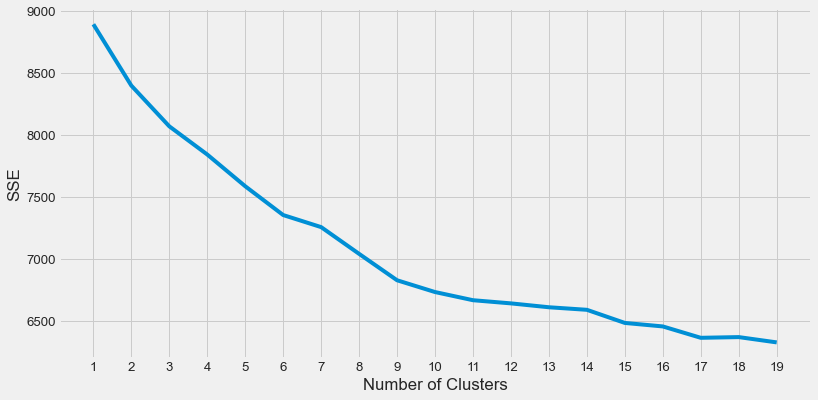

In [18]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,6))
plt.plot(range(1, 20), scores)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

## Model Building

### Using Original Data

In [19]:
categorical_features = ['in_reply','subj_caps','attachments']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clfPipeline = Pipeline(steps = [['preprocessor', preprocessor],['classifier', MultinomialNB()]])


clfPipeline.fit(X_train, y_train)

y_pred = clfPipeline.predict(X_test)

print("Accurracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))

Accurracy: 0.7856761090326029
Recall: 0.2375
Precision: 0.7651006711409396
F1 0.36248012718600947


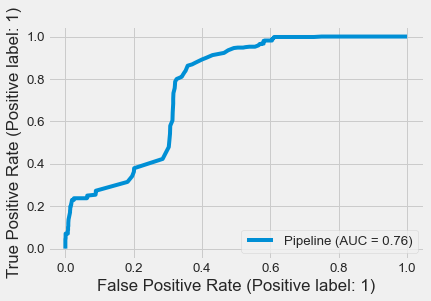

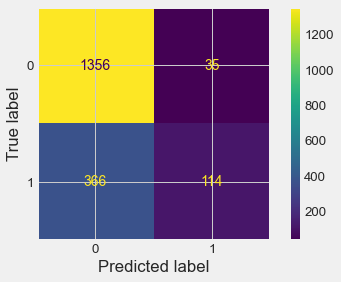

In [20]:
disp = RocCurveDisplay.from_estimator(clfPipeline, X_test, y_test)
disp = ConfusionMatrixDisplay.from_estimator(clfPipeline, X_test, y_test)

### Using Previously Identified Clusters

In [21]:
categorical_features = ['in_reply','subj_caps','attachments','kmeans_cluster']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clfPipeline = Pipeline(steps = [['preprocessor', preprocessor],['classifier', MultinomialNB()]])


clfPipeline.fit(X_train, y_train)

y_pred = clfPipeline.predict(X_test)

print("Accurracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))

Accurracy: 0.8856226616782469
Recall: 0.8979166666666667
Precision: 0.7231543624161074
F1 0.8011152416356878


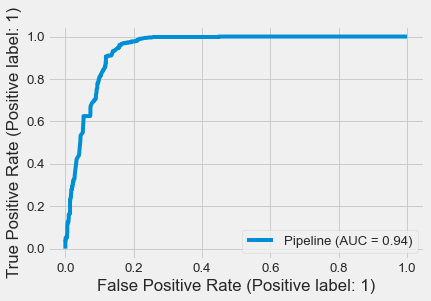

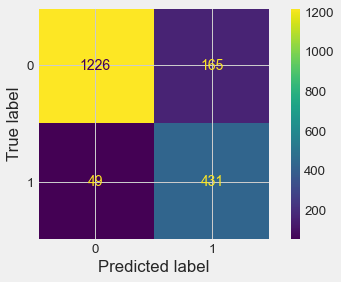

In [22]:
disp = RocCurveDisplay.from_estimator(clfPipeline, X_test, y_test)
disp = ConfusionMatrixDisplay.from_estimator(clfPipeline, X_test, y_test)